
# **Ввести предикатную цену акции**

---
Фондовый рынок — это публичный рынок, на котором вы можете покупать и продавать акции публичных компаний. Акции, также известные как акции, представляют собой право собственности на компанию. Фондовая биржа является посредником, который позволяет покупать и продавать акции.

---
**Подготовить набор данных**

---
Мы загружаем набор данных о ценах на акции Google с 1 января 2015 года по 1 сентября 2022 года.
Мы используем метод LSTM от Pytorch для прогнозирования цены акций.

---
**Цены на акции бывают разных форм**
* Открытие: цена акции на открытии дня.
* Закрытие: цена акции закрытия дня
* Высокий: самая высокая цена акций данных
* Низкий: самая низкая цена акции за день.

На веб-сайте показана эта модель LSTM.
https://d2l.ai/chapter_recurrent-modern/lstm.html


In [1]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2022,9,1)
data = web.DataReader('GOOGL', 'stooq', start, end)

**Просмотреть функции набора данных и убедить, что количество функций** 

In [2]:
import numpy as np
import pandas as pd
data = data.sort_values('Date')
# data = data.reset_index()

print(data.head())
print(data.shape)

               Open     High      Low    Close    Volume
Date                                                    
2015-01-02  26.6300  26.7900  26.3940  26.4775  26553300
2015-01-05  26.3575  26.3995  25.8875  25.9730  41141780
2015-01-06  26.0250  26.0605  25.2775  25.3320  54634560
2015-01-07  25.5475  25.5745  25.1825  25.2575  46916460
2015-01-08  25.0580  25.3750  24.7510  25.3455  73243380
(1931, 5)


**Визуализация данных**


---
Мне нужны данные с различными закономерностями, возникающими с течением времени.



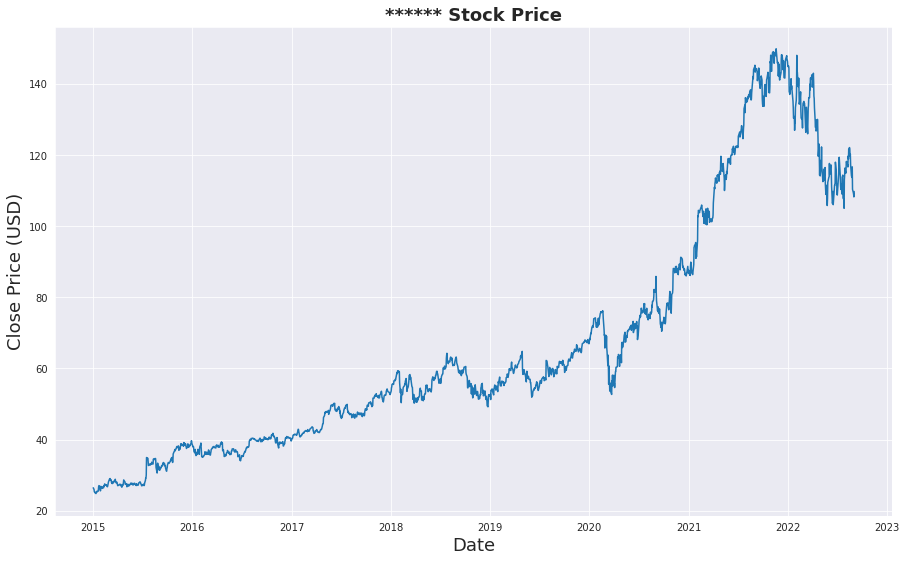

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
# plt.xticks(range(0,data.shape[0],500), data['Date'].loc[::10], rotation=45)
plt.title("****** Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

# **Особенности выбирают**
**Выбрать ценовую метку закрытия['Close'] и распечатать информацию о ней**

In [4]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1931 entries, 2015-01-02 to 2022-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1931 non-null   float64
dtypes: float64(1)
memory usage: 30.2 KB


**Использовать MinMaxScaler для изменения диапазона функций** 



In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-5-77e3f41ac3d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [6]:
price['Close'].shape

(1931,)

# **Разделение данных на обучающий набор данных и тестовый набор данных**


In [7]:
pre=1
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-pre,:]
    y_train = data[:train_set_size,-pre,:]
    
    x_test = data[train_set_size:,:-pre]
    y_test = data[train_set_size:,-pre,:]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1529, 19, 1)
y_train.shape =  (1529, 1)
x_test.shape =  (382, 19, 1)
y_test.shape =  (382, 1)


# **Модель сборки — LSTM**

In [9]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

**Pytorch LSTM Model**
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [10]:
input_dim = 1 #The number of expected features in the input x
hidden_dim = 32 #The number of features in the hidden state h
num_layers = 2 #Number of recurrent layers
output_dim = 1
num_epochs = 100

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)#[batch,length,Hin]
        self.fc = nn.Linear(hidden_dim, output_dim)#Full connect layers
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #hidden
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # cell state
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # record all the cell state
        
        out = self.fc(out[:, -pre, :]) #choose final the element of cell statement  

        return out

In [12]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()#MSE is average squared difference between estimated values and actual values
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)#

# **Тренировочная модель**


In [13]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.30886396765708923
Epoch  1 MSE:  0.1635044664144516
Epoch  2 MSE:  0.06368924677371979
Epoch  3 MSE:  0.15655435621738434
Epoch  4 MSE:  0.07710522413253784
Epoch  5 MSE:  0.0545894093811512
Epoch  6 MSE:  0.06408043205738068
Epoch  7 MSE:  0.07407879829406738
Epoch  8 MSE:  0.07752075791358948
Epoch  9 MSE:  0.0748283639550209
Epoch  10 MSE:  0.06806869804859161
Epoch  11 MSE:  0.05964205041527748
Epoch  12 MSE:  0.05207443609833717
Epoch  13 MSE:  0.04775610193610191
Epoch  14 MSE:  0.04798441007733345
Epoch  15 MSE:  0.051266785711050034
Epoch  16 MSE:  0.05311831831932068
Epoch  17 MSE:  0.0499119833111763
Epoch  18 MSE:  0.042802371084690094
Epoch  19 MSE:  0.03571682423353195
Epoch  20 MSE:  0.031150026246905327
Epoch  21 MSE:  0.02882520668208599
Epoch  22 MSE:  0.026437697932124138
Epoch  23 MSE:  0.020890753716230392
Epoch  24 MSE:  0.011186703108251095
Epoch  25 MSE:  0.005634058266878128
Epoch  26 MSE:  0.012340156361460686
Epoch  27 MSE:  0.0093751922249794

In [14]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

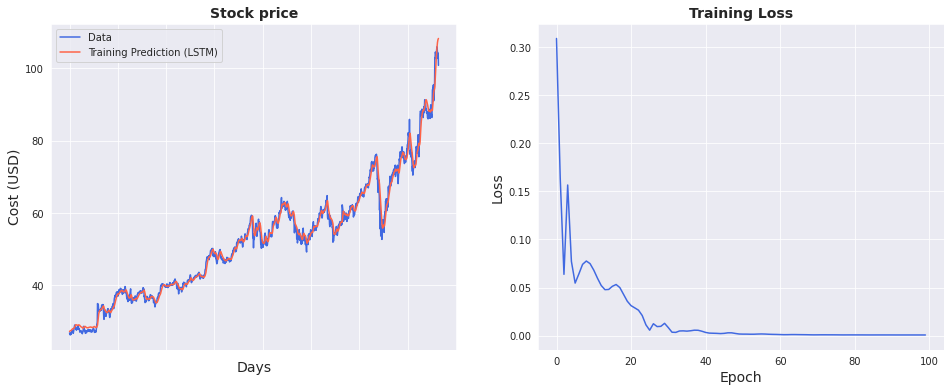

In [15]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# **модель проверки**

In [16]:
x_test[-pre]

tensor([[0.4936],
        [0.4820],
        [0.4793],
        [0.4686],
        [0.5177],
        [0.5040],
        [0.5494],
        [0.5558],
        [0.5497],
        [0.5153],
        [0.5253],
        [0.4779],
        [0.4304],
        [0.4243],
        [0.4216],
        [0.4689],
        [0.3680],
        [0.3532],
        [0.3456]])

In [17]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 1.60 RMSE
Test Score: 10.30 RMSE


In [18]:
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-pre:len(price)-pre, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [19]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()